In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az

from sklearn.preprocessing import StandardScaler, MinMaxScaler

ModuleNotFoundError: No module named 'seaborn'

## 1. Импорт и  первичный анализ данных

In [5]:
data = pd.read_csv('data/flats.zip')
data.head()

,Unnamed: 0,price_doc,full_sq,life_sq,num_room,kitch_sq
0,8056,2750000,11,11.0,1.0,12.0
1,8154,7100000,45,27.0,2.0,6.0
2,8287,11700000,77,50.0,3.0,8.0
3,8387,10400000,56,29.0,2.0,10.0
4,8391,6200000,31,21.0,1.0,5.0


Проверим данные на пропуски

In [6]:
data.isna().sum()

Unnamed: 0    0
price_doc     0
full_sq       0
life_sq       0
num_room      0
kitch_sq      0
dtype: int64

In [7]:
data.describe()

,Unnamed: 0,price_doc,full_sq,life_sq,num_room,kitch_sq
count,6042.000000,6.042000e+03,6042.000000,6042.000000,6042.000000,6042.000000
mean,19846.990070,8.750423e+06,53.374545,33.198941,1.997021,7.391096
std,6081.011373,6.277290e+06,24.011941,20.190005,0.889523,3.806198
min,8056.000000,5.000000e+05,1.000000,0.000000,0.000000,0.000000
25%,14573.250000,5.800000e+06,38.000000,20.000000,1.000000,5.000000
50%,19871.500000,7.400000e+06,46.000000,29.000000,2.000000,7.000000
75%,25147.750000,1.050000e+07,63.000000,42.000000,3.000000,9.000000
max,30470.000000,9.512250e+07,637.000000,637.000000,17.000000,96.000000


Есть подозрение, что "Unnamed: 0" это столбец ранее использовавшийся как индекс. Для подтверждения проверим последние строки.

In [8]:
data.tail()

,Unnamed: 0,price_doc,full_sq,life_sq,num_room,kitch_sq
6037,30462,10544070,47,30.0,1.0,10.0
6038,30463,12000000,56,29.0,2.0,11.0
6039,30467,25000000,86,59.0,4.0,10.0
6040,30469,13500000,64,32.0,2.0,11.0
6041,30470,5600000,43,28.0,2.0,6.0


Удаляем столбец "Unnamed: 0".

In [9]:
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,price_doc,full_sq,life_sq,num_room,kitch_sq
0,2750000,11,11.0,1.0,12.0
1,7100000,45,27.0,2.0,6.0
2,11700000,77,50.0,3.0,8.0
3,10400000,56,29.0,2.0,10.0
4,6200000,31,21.0,1.0,5.0


## 2. Разведывательный анализ данных

Рассмотрим распределение данных.

NameError: name 'sns' is not defined

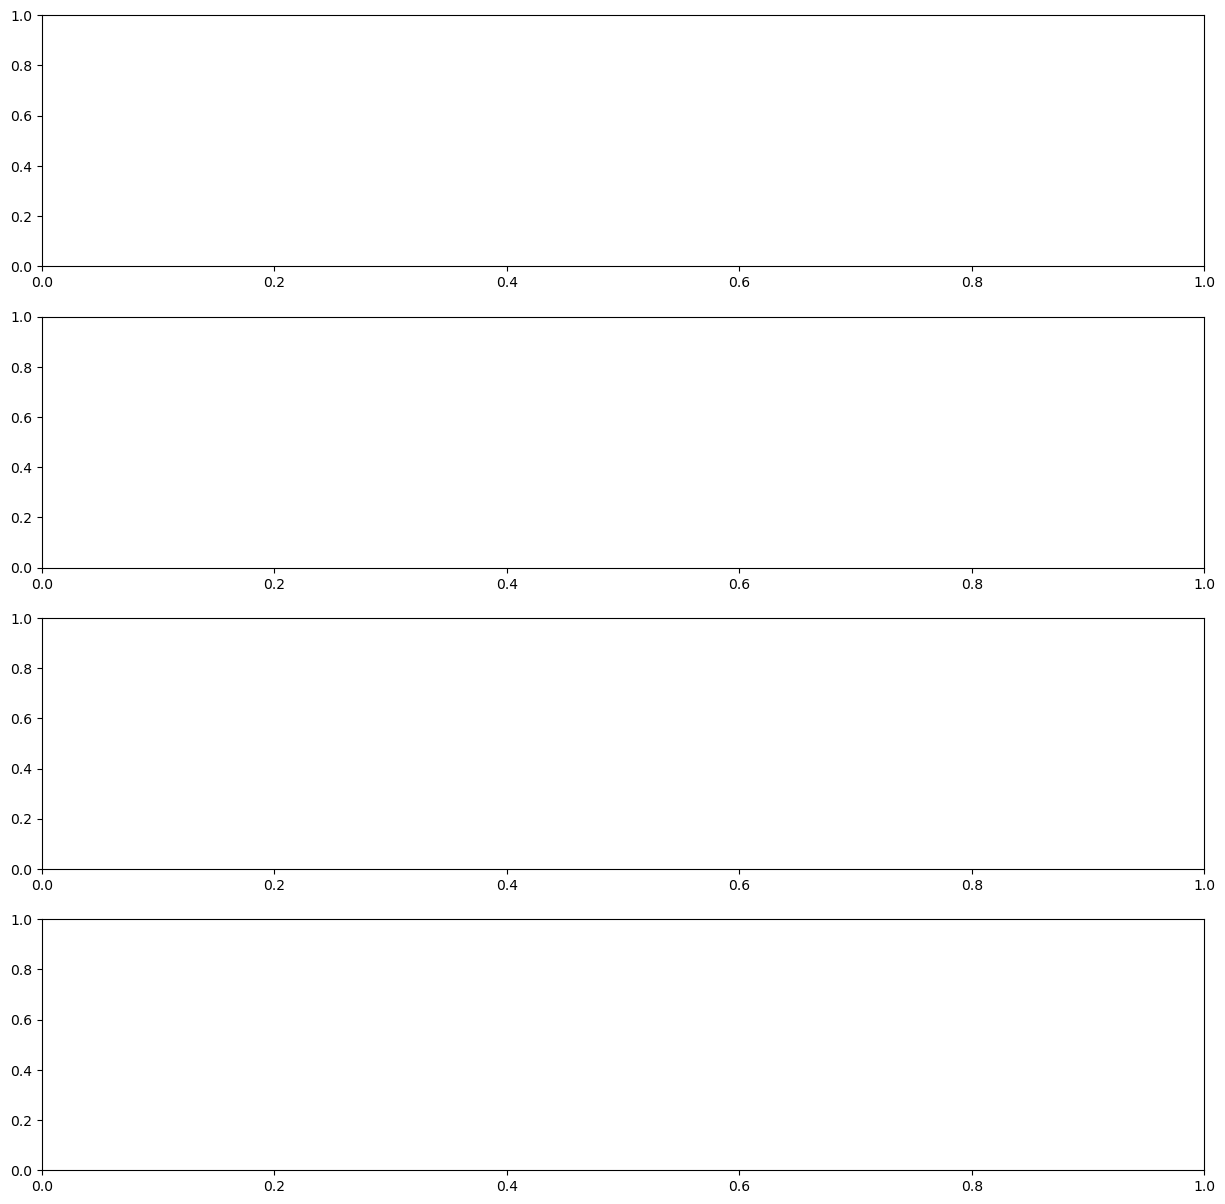

In [10]:
fig, axes = plt.subplots(nrows=4, figsize=(15, 15))

sns.boxplot(x=data.full_sq, ax=axes[0])
axes[0].set(xlabel="Площадь")
axes[0].grid()

sns.boxplot(x=data.life_sq, ax=axes[1])
axes[1].set(xlabel="Жилая площадь")
axes[1].grid()

sns.boxplot(x=data.num_room, ax=axes[2])
axes[2].set(xlabel="Количество комнат")
axes[2].grid()

sns.boxplot(x=data.kitch_sq, ax=axes[3])
axes[3].set(xlabel="Площадь кухни")
axes[3].grid()

Распределение можно считать нормальным. Однако есть выбросы. Предлагаю их удалить.

In [ ]:
def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=True):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [ ]:
_, data = outliers_iqr_mod(data, 'full_sq', log_scale=False)
_, data = outliers_iqr_mod(data, 'life_sq', log_scale=False)
_, data = outliers_iqr_mod(data, 'num_room', log_scale=False)
_, data = outliers_iqr_mod(data, 'kitch_sq', log_scale=False)

data.reset_index(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5682 entries, 0 to 5681
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      5682 non-null   int64  
 1   price_doc  5682 non-null   int64  
 2   full_sq    5682 non-null   int64  
 3   life_sq    5682 non-null   float64
 4   num_room   5682 non-null   float64
 5   kitch_sq   5682 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 266.5 KB


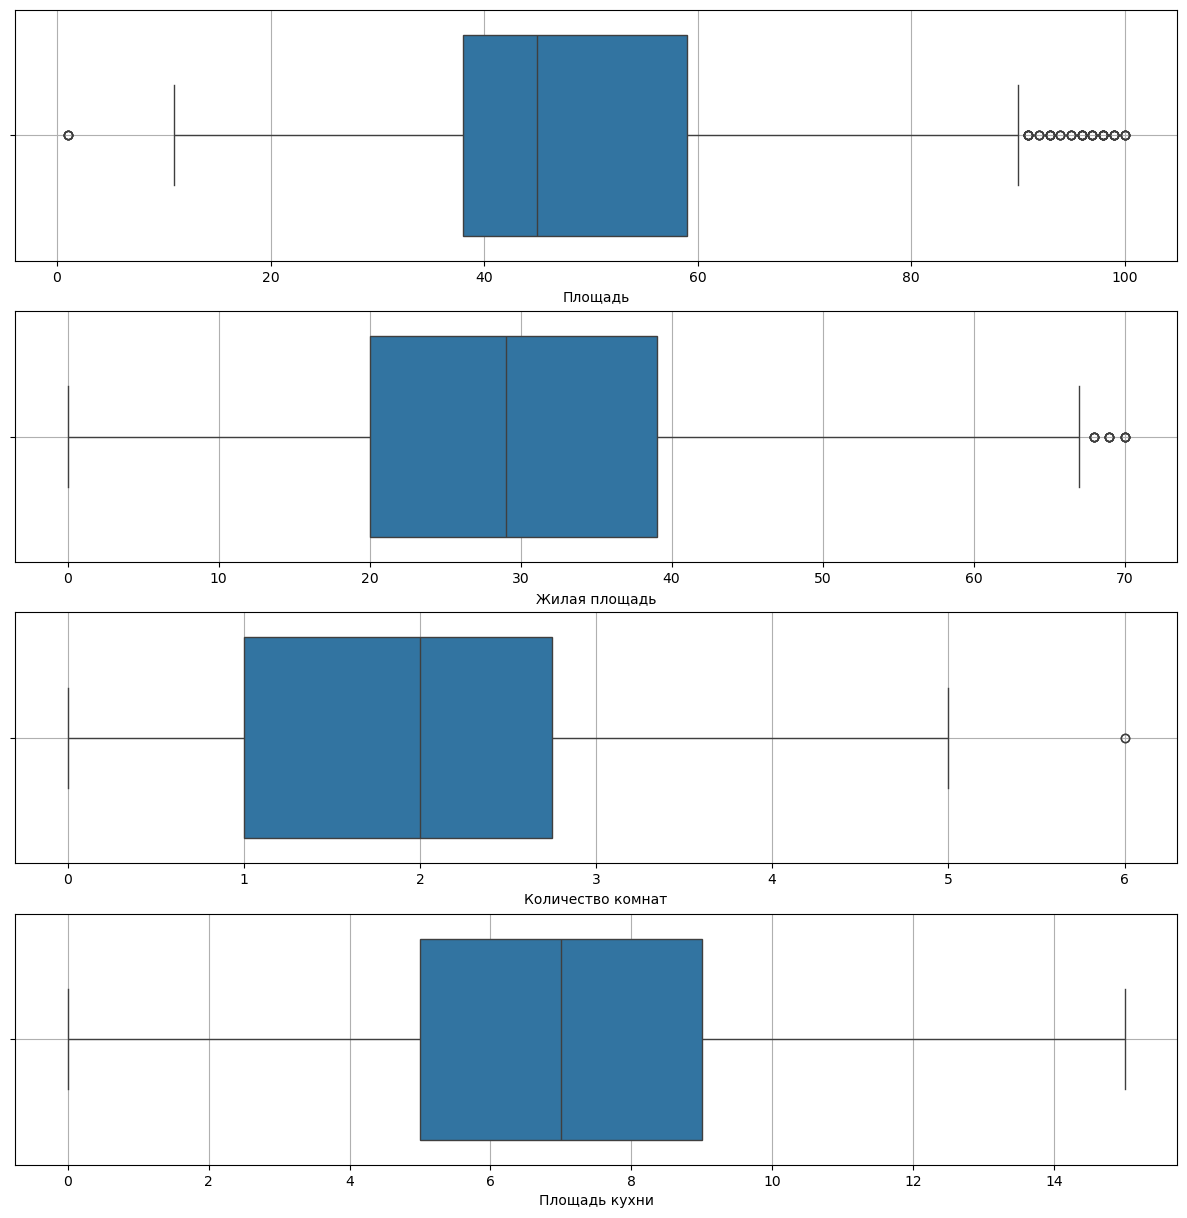

In [ ]:
fig, axes = plt.subplots(nrows=4, figsize=(15, 15))

sns.boxplot(x=data.full_sq, ax=axes[0])
axes[0].set(xlabel="Площадь")
axes[0].grid()

sns.boxplot(x=data.life_sq, ax=axes[1])
axes[1].set(xlabel="Жилая площадь")
axes[1].grid()

sns.boxplot(x=data.num_room, ax=axes[2])
axes[2].set(xlabel="Количество комнат")
axes[2].grid()

sns.boxplot(x=data.kitch_sq, ax=axes[3])
axes[3].set(xlabel="Площадь кухни")
axes[3].grid()

## 3. Предобработка данных

In [ ]:
s_scaler = MinMaxScaler()

# кодируем исходный датасет
data_scaled = pd.DataFrame(s_scaler.fit_transform(data[['full_sq', 'life_sq', 'num_room', 'kitch_sq']]), columns=['full_sq', 'life_sq', 'num_room', 'kitch_sq'])

data_scaled.describe()

,full_sq,life_sq,num_room,kitch_sq
count,5682.000000,5682.000000,5682.000000,5682.000000
mean,0.490946,0.433210,0.322011,0.469776
std,0.161336,0.167866,0.133442,0.162190
min,0.000000,0.000000,0.000000,0.000000
25%,0.373737,0.285714,0.166667,0.333333
50%,0.444444,0.414286,0.333333,0.466667
75%,0.585859,0.557143,0.458333,0.600000
max,1.000000,1.000000,1.000000,1.000000


## 3. Построение байесовской модели

In [ ]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('income ~ age + age2 + marital + educ ', data, family = pm.glm.families.Binomial())
    trace = pm.sample(1000)

NameError: name 'data' is not defined